In [1]:
from src.model.dinov2 import CustomDINOv2
import torch
descriptor_model = CustomDINOv2(
        model_name="dinov2_vitl14",
        model=torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14'),
        token_name="x_norm_clstoken",
        image_size=224,
        chunk_size=16,
        descriptor_width_size=640,
        patch_size=14,
)

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [27]:
# from torchvision.io import read_image
# import torch
# #convert image to size of 224*224 as redered templates
# image = read_image("datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_000001/000002.png")
# resize = transforms.Resize((224, 224))
# image_resized = resize(image)
# rgb_image = image_resized[:3].unsqueeze(0)
# dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')


Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main


In [30]:
# # Resize the image to 224x224
# dinov2.eval()
# with torch.no_grad():
#     features = dinov2(image_resized)

ValueError: not enough values to unpack (expected 4, got 3)

In [33]:
import torch
from torchvision import transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt

# Load the image
image_path = "datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_000001/000002.png"
image = read_image(image_path)

# Remove the alpha channel if it exists
if image.shape[0] == 4:
    image = image[:3]

# Resize the image to 224x224
resize = transforms.Resize((224, 224))
image_resized = resize(image)

# Normalize the image
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
image_normalized = normalize(image_resized.float() / 255.0)

# Add a batch dimension
image_batch = image_normalized.unsqueeze(0).to("cuda:0")

# Load the DINOv2 model
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14').to("cuda:0")

# Ensure the model is in evaluation mode
dinov2.eval()

# Extract features
with torch.no_grad():
    features = dinov2(image_batch)


Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main


In [36]:
features.shape

torch.Size([1, 1024])

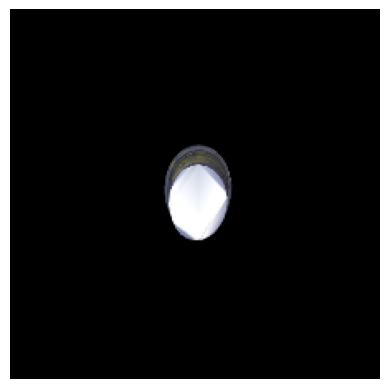

torch.Size([1, 1024])


In [34]:
# Plot the original image
plt.imshow(image_resized.permute(1, 2, 0).byte())
plt.axis('off')
plt.show()

# Print the shape of the extracted features
print(features.shape)


In [17]:
rgb_image = image[:3]
rgb_image.shape

torch.Size([3, 480, 640])

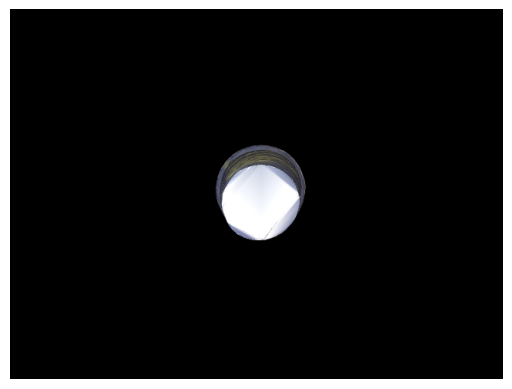

In [18]:
import matplotlib.pyplot as plt
image_resized = rgb_image.permute(1, 2, 0)

# Plot the image using matplotlib
plt.imshow(image_resized)
plt.axis('off')  # Turn off axis labels
plt.show()

In [136]:
from PIL import Image
import torch
import numpy as np
import json
boxes, templates = [], []
# file path datasets/bop23_challenge/results/cnos_exps/visualization/sam_pbr_icbin/icbin000001/000008.png
rgb_path = "datasets/bop23_challenge/datasets/icbin/test/000001/rgb/000002.png"
mask_path = "datasets/bop23_challenge/datasets/icbin/test/000001/mask_visib/000002_000006.png"
scene_gt_info = json.load(open("datasets/bop23_challenge/datasets/icbin/test/000001/scene_gt_info.json", 'r'))
scene_gt = json.load(open("datasets/bop23_challenge/datasets/icbin/test/000001/scene_gt.json", 'r'))
rgb = Image.open(rgb_path) # rgb path = datasets/bop23_challenge/datasets/icbin/train_pbr/000003/rgb/000725.jpg
mask = Image.open(mask_path) # mask_path = /datasets/bop23_challenge/datasets/icbin/train_pbr/000003/mask_visib/000725_000018.png
masked_rgb = Image.composite(
    rgb, Image.new("RGB", rgb.size, (0, 0, 0)), mask
)
boxes.append(mask.getbbox())
# image = torch.from_numpy(np.array(masked_rgb.convert("RGB")) / 255).float() # torch.Size([480, 640, 3])
image = torch.from_numpy(np.array(masked_rgb.convert("RGB"))) # torch.Size([480, 640, 3])
templates.append(image)

In [145]:
templates[0].shape

torch.Size([480, 640, 3])

In [81]:
R, t = np.array(scene_gt["2"][6]["cam_R_m2c"]).reshape(3,3), np.array(scene_gt["2"][6]["cam_t_m2c"])*0.4
template_pose = np.eye(4)
template_pose[:3,:3] = R
template_pose[:3, 3] = t
template_poses = []
template_poses.append(template_pose)
np.save("custom_template_poses.npy", template_poses)

In [88]:
import os, sys
import numpy as np
import shutil
from tqdm import tqdm
import time
from functools import partial
import multiprocessing
import logging
import os, sys
import os.path as osp
from src.poses.utils import get_obj_poses_from_template_level

# set level logging
logging.basicConfig(level=logging.INFO)
import logging
import hydra
from omegaconf import DictConfig, OmegaConf
import numpy as np

cad_path = "datasets/bop23_challenge/datasets/icbin/models/models/obj_000001.ply"
obj_pose_path = "feature_comparision_test/custom_template_poses.npy"
output_dir = "feature_comparision_test/obj_000001"
gpus_devices = "0,1,2,3"
disable_output = True

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

command = f"python -m src.poses.pyrender {cad_path} {obj_pose_path} {output_dir} {gpus_devices}"
if disable_output:
    command += " true"
else:
    command += " false"
os.system(command)

Namespace(cad_path='datasets/bop23_challenge/datasets/icbin/models/models/obj_000001.ply', obj_pose='feature_comparision_test/custom_template_poses.npy', output_dir='feature_comparision_test/obj_000001', gpus_devices='0,1,2,3', disable_output='true', light_itensity=0.6, radius=1)


0

In [37]:
# crop template from proposals- just get the crop one for the mask not the whole image input
from src.utils.bbox_utils import CropResizePad
processing_config = {'image_size': 224, 'max_num_scenes': 10, 'max_num_frames': 500, 'min_visib_fract': 0.8, 'num_references': 200, 'use_visible_mask': True}
proposal_processor = CropResizePad(processing_config["image_size"])

In [38]:
import torchvision.transforms as T
rgb_transform = T.Compose(
    [
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

In [39]:
templates = torch.stack(templates).permute(0, 3, 1, 2) # to get (Np, 3, 480,640)
boxes = torch.tensor(np.array(boxes))
templates_croped = proposal_processor(images=templates, boxes=boxes)
templates_output = {"templates": rgb_transform(templates_croped)} # to normalize the template 

In [40]:
torch.max(templates_output["templates"])

tensor(2.6400)

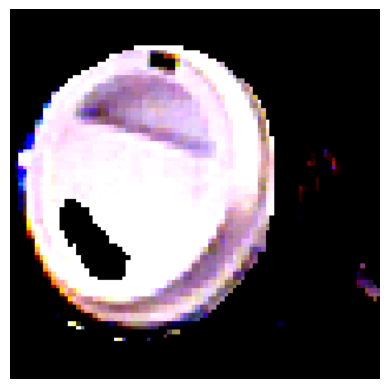

In [141]:
import matplotlib.pyplot as plt
image_resized = templates_output["templates"][0].permute(1, 2, 0)

# Plot the image using matplotlib
plt.imshow(image_resized)
plt.axis('off')  # Turn off axis labels
plt.show()

In [43]:
from src.model.loss import PairwiseSimilarity
cosine_similarity = PairwiseSimilarity(metric="cosine", chunk_size=16)

In [44]:
query = templates_output["templates"][0]

In [133]:
from torchvision.io import read_image
reference = read_image("feature_comparision_test/obj_000001/000000.png")[:3]
# reference = torch.from_numpy(np.array(reference.convert("RGB")) / 255).float() # torch.Size([480, 640, 3])

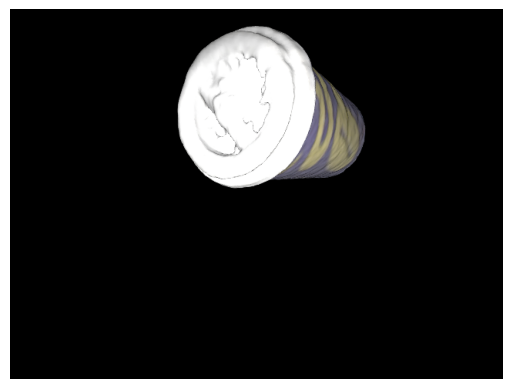

In [170]:
import matplotlib.pyplot as plt
# Plot the image using matplotlib
plt.imshow(reference.permute(1,2,0))
plt.axis('off')  # Turn off axis labels
plt.show()

In [174]:
from PIL import Image
import torch
import numpy as np
import json
boxes, templates = [], []
# file path datasets/bop23_challenge/results/cnos_exps/visualization/sam_pbr_icbin/icbin000001/000008.png
rgb_path = "datasets/bop23_challenge/datasets/icbin/test/000001/rgb/000002.png"
mask_path = "datasets/bop23_challenge/datasets/icbin/test/000001/mask_visib/000002_000006.png"
scene_gt_info = json.load(open("datasets/bop23_challenge/datasets/icbin/test/000001/scene_gt_info.json", 'r'))
scene_gt = json.load(open("datasets/bop23_challenge/datasets/icbin/test/000001/scene_gt.json", 'r'))
rgb = Image.open(rgb_path) # rgb path = datasets/bop23_challenge/datasets/icbin/train_pbr/000003/rgb/000725.jpg
mask = Image.open(mask_path) # mask_path = /datasets/bop23_challenge/datasets/icbin/train_pbr/000003/mask_visib/000725_000018.png
masked_rgb = Image.composite(
    rgb, Image.new("RGB", rgb.size, (0, 0, 0)), mask
)
boxes.append(mask.getbbox())
# image = torch.from_numpy(np.array(masked_rgb.convert("RGB")) / 255).float() # torch.Size([480, 640, 3])
image = torch.from_numpy(np.array(masked_rgb.convert("RGB")))# torch.Size([480, 640, 3])
templates.append(image)
templates = torch.stack(templates).permute(0, 3, 1, 2)

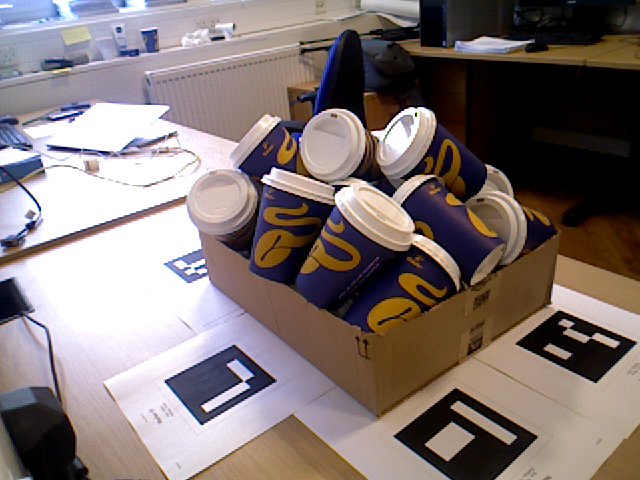

In [180]:
rgb

In [175]:

boxes = torch.tensor(np.array(boxes))
templates_croped = proposal_processor(images=templates, boxes=boxes)
# templates_output = {"templates": rgb_transform(templates_croped)} # to normalize the template 

In [185]:
templates_croped[0].shape

torch.Size([3, 224, 224])

In [186]:
# from torchvision.utils import save_image
# save_image(templates_croped[0],"feature_comparision_test/obj_000001/proposals")

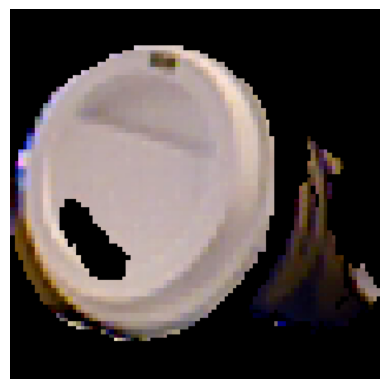

In [177]:
import matplotlib.pyplot as plt
# Plot the image using matplotlib
plt.imshow(templates_croped[0].permute(1, 2, 0))
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
# templates_croped[0] and  reference using them to compare the cosine similarity
from src.model.loss import PairwiseSimilarity
cosine_similarity = PairwiseSimilarity(metric="cosine", chunk_size=16)

In [187]:
import torch
from torchvision import transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt

# Load the image
image_path = "feature_comparision_test/obj_000001/000000.png"
image = read_image(image_path)

# Remove the alpha channel if it exists
if image.shape[0] == 4:
    image = image[:3]

# Resize the image to 224x224
resize = transforms.Resize((224, 224))
image_resized = resize(image)

# Normalize the image
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
image_normalized = normalize(image_resized.float() / 255.0)

# Add a batch dimension
image_batch = image_normalized.unsqueeze(0).to("cuda:0")

# Load the DINOv2 model
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14').to("cuda:0")

# Ensure the model is in evaluation mode
dinov2.eval()

# Extract features
with torch.no_grad():
    template_features = dinov2(image_batch)

/home/cuong.vandam/miniconda3/envs/cnos/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main
INFO:dinov2:using MLP layer as FFN


In [188]:
import torch
from torchvision import transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt

# Load the image
image = templates_croped[0]

# Remove the alpha channel if it exists
if image.shape[0] == 4:
    image = image[:3]

# Resize the image to 224x224
resize = transforms.Resize((224, 224))
image_resized = resize(image)

# Normalize the image
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
image_normalized = normalize(image_resized.float() / 255.0)

image_batch = image_normalized.unsqueeze(0).to("cuda:0")

dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14').to("cuda:0")

dinov2.eval()

with torch.no_grad():
    proposal_features = dinov2(image_batch)

/home/cuong.vandam/miniconda3/envs/cnos/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main
INFO:dinov2:using MLP layer as FFN


In [192]:
proposal_features.shape

torch.Size([1, 1024])

In [191]:
template_features.shape

torch.Size([1, 1024])

In [196]:
from torch.nn.functional import cosine_similarity
output = cosine_similarity(template_features, proposal_features)
output

tensor([0.3311], device='cuda:0')